In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow --quiet

In [3]:
!pip install keras-self-attention --quiet

  Preparing metadata (setup.py) ... done


In [4]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Reshape, Flatten
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [5]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [6]:
# Read in the Silver dataset from a CSV file
df=pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Silver_Data.csv")
df=df.set_index(pd.DatetimeIndex(df['Date'].values))


# Preprocessing Data

---

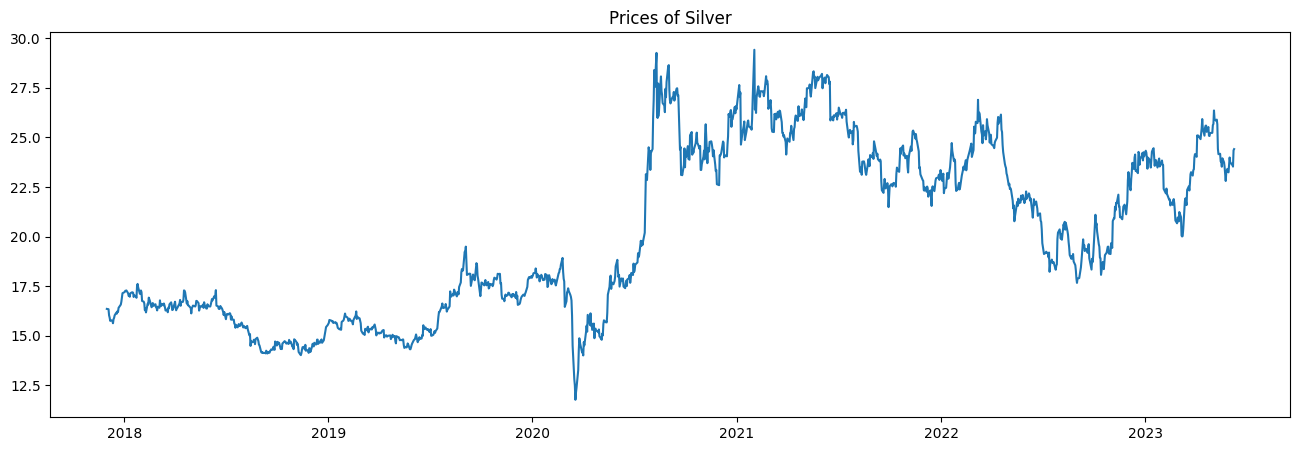

In [7]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Flip the column
df = df.iloc[::-1]

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Price'])
df1.drop('Date', axis = 1, inplace = True)

# Plot the 'price' column of the 'df' DataFrame
plt.figure(figsize=(16,5))
plt.plot(df1['Price'])
plt.title('Prices of Silver')
plt.show()

# Split dataset (7-2-1)

---



In [8]:
# Convert the 'df1' DataFrame to a NumPy array
data = df1.values

# Split the data (7-2-1)
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [9]:
# Create a MinMaxScaler object with a specified range
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

In [10]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [11]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [12]:
from keras.models import Model
from keras.layers import Dense, Input, SimpleRNN, Attention

input_seq = Input(shape=(5, 1))
rnn_output = SimpleRNN(50, return_sequences=True)(input_seq)
attention_output = Attention()([rnn_output, rnn_output])
reshaped_output = Reshape((-1,))(attention_output)
output = Dense(1)(reshaped_output)

model = Model(inputs=input_seq, outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam')

save_model = 'save_model(7-2-1).hdf5'
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])


Epoch 1/80

Epoch 1: loss improved from inf to 0.03397, saving model to save_model(7-2-1).hdf5
20/20 - 1s - loss: 0.0340 - 1s/epoch - 53ms/step
Epoch 2/80

Epoch 2: loss improved from 0.03397 to 0.00368, saving model to save_model(7-2-1).hdf5
20/20 - 0s - loss: 0.0037 - 53ms/epoch - 3ms/step
Epoch 3/80

Epoch 3: loss improved from 0.00368 to 0.00145, saving model to save_model(7-2-1).hdf5
20/20 - 0s - loss: 0.0014 - 52ms/epoch - 3ms/step
Epoch 4/80

Epoch 4: loss improved from 0.00145 to 0.00127, saving model to save_model(7-2-1).hdf5
20/20 - 0s - loss: 0.0013 - 53ms/epoch - 3ms/step
Epoch 5/80

Epoch 5: loss did not improve from 0.00127
20/20 - 0s - loss: 0.0013 - 48ms/epoch - 2ms/step
Epoch 6/80

Epoch 6: loss did not improve from 0.00127
20/20 - 0s - loss: 0.0013 - 41ms/epoch - 2ms/step
Epoch 7/80

Epoch 7: loss improved from 0.00127 to 0.00126, saving model to save_model(7-2-1).hdf5
20/20 - 0s - loss: 0.0013 - 53ms/epoch - 3ms/step
Epoch 8/80

Epoch 8: loss did not improve from 0.0

In [13]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model(7-2-1).hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

31/31 [==============================] - 0s 3ms/step


In [14]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

9/9 [==============================] - 0s 2ms/step


In [15]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 [==============================] - 0s 3ms/step


In [16]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[sc_train.shape[0]-5:].reshape(1, -1)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps,1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.6711223125457764], [0.6501696109771729], [0.610351026058197], [0.5860269665718079], [0.5646159052848816], [0.5397155284881592], [0.521450400352478], [0.49969491362571716], [0.48059770464897156], [0.4625949561595917], [0.4444325566291809], [0.4283604323863983], [0.4122568964958191], [0.397239625453949], [0.3829929232597351], [0.36918380856513977], [0.35627880692481995], [0.3438148498535156], [0.33199506998062134], [0.3207383155822754], [0.30994534492492676], [0.2996956706047058], [0.2898717224597931], [0.28049665689468384], [0.27153709530830383], [0.2629544734954834], [0.2547506093978882], [0.24688588082790375], [0.23935171961784363], [0.23212848603725433]]


In [17]:
# Convert the 'date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 15 days
datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

<Figure size 1600x500 with 0 Axes>

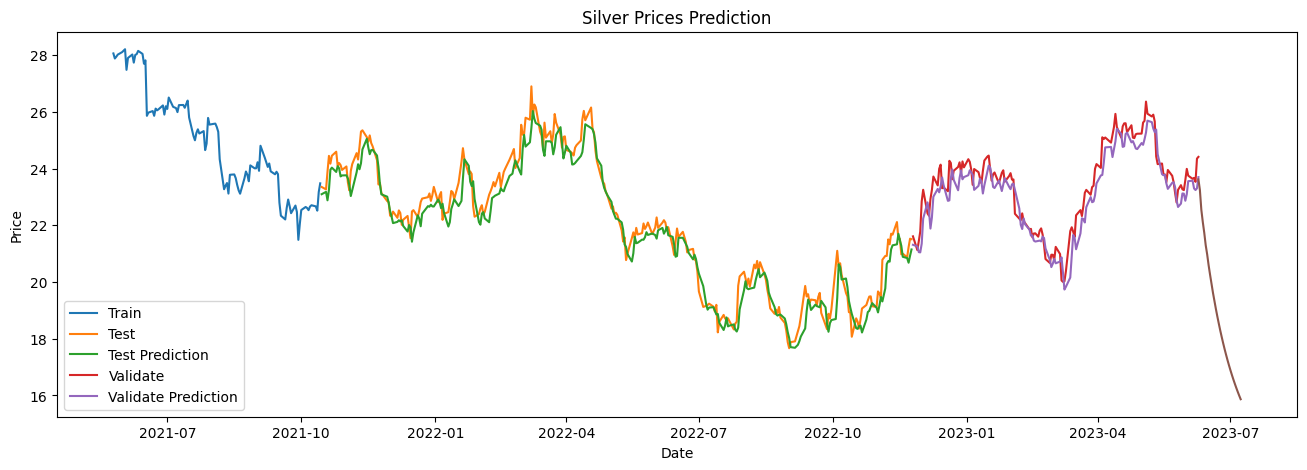

In [18]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Silver Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [19]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.4041476920378124
MAPE:  1.8284930320904298
RMSE:  0.531895984166395

** Validate **
MAE:  0.45360785061496106
MAPE:  1.927080633204241
RMSE:  0.5688340476510796


# Split dataset (6-3-1)

---



In [20]:
# 4. Split data (6-3-1)
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [21]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [22]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [23]:
# Build the model
model = Sequential()

# Add an LSTM layer with 64 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(LSTM(units=64, input_shape=(x_train.shape[1], 1), return_sequences=True,kernel_regularizer=l2(0.01)))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=True))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=False))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_6_3_1.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.23214, saving model to save_model_6_3_1.hdf5
17/17 - 10s - loss: 0.2321 - 10s/epoch - 583ms/step
Epoch 2/80

Epoch 2: loss improved from 0.23214 to 0.10549, saving model to save_model_6_3_1.hdf5
17/17 - 0s - loss: 0.1055 - 396ms/epoch - 23ms/step
Epoch 3/80

Epoch 3: loss improved from 0.10549 to 0.05652, saving model to save_model_6_3_1.hdf5
17/17 - 0s - loss: 0.0565 - 300ms/epoch - 18ms/step
Epoch 4/80

Epoch 4: loss improved from 0.05652 to 0.05008, saving model to save_model_6_3_1.hdf5
17/17 - 0s - loss: 0.0501 - 333ms/epoch - 20ms/step
Epoch 5/80

Epoch 5: loss improved from 0.05008 to 0.04593, saving model to save_model_6_3_1.hdf5
17/17 - 0s - loss: 0.0459 - 279ms/epoch - 16ms/step
Epoch 6/80

Epoch 6: loss improved from 0.04593 to 0.04108, saving model to save_model_6_3_1.hdf5
17/17 - 0s - loss: 0.0411 - 300ms/epoch - 18ms/step
Epoch 7/80

Epoch 7: loss improved from 0.04108 to 0.03715, saving model to save_model_6_3_1.hdf5
17/17 

In [24]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_6_3_1.hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

27/27 [==============================] - 1s 3ms/step


In [25]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 [==============================] - 0s 3ms/step


In [26]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 [==============================] - 0s 3ms/step


In [27]:
# Predict the next 30 days
x_input=sc_train[sc_train.shape[0]-5:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=5
i=0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

# Print the final list of predictions
print(lst_output)

[0.6834358]
6
[0.6834358]
7
[0.6834358]
8
[0.6834358]
9
[0.6834358]
10
[0.6834358]
11
[0.6834358]
12
[0.6834358]
13
[0.6834358]
14
[0.6834358]
15
[0.6834358]
16
[0.6834358]
17
[0.6834358]
18
[0.6834358]
19
[0.6834358]
20
[0.6834358]
21
[0.6834358]
22
[0.6834358]
23
[0.6834358]
24
[0.6834358]
25
[0.6834358]
26
[0.6834358]
27
[0.6834358]
28
[0.6834358]
29
[0.6834358]
30
[0.6834358]
31
[0.6834358]
32
[0.6834358]
33
[0.6834358]
34
[0.6834358]
35
[[0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.6834357976913452], [0.

<Figure size 1600x500 with 0 Axes>

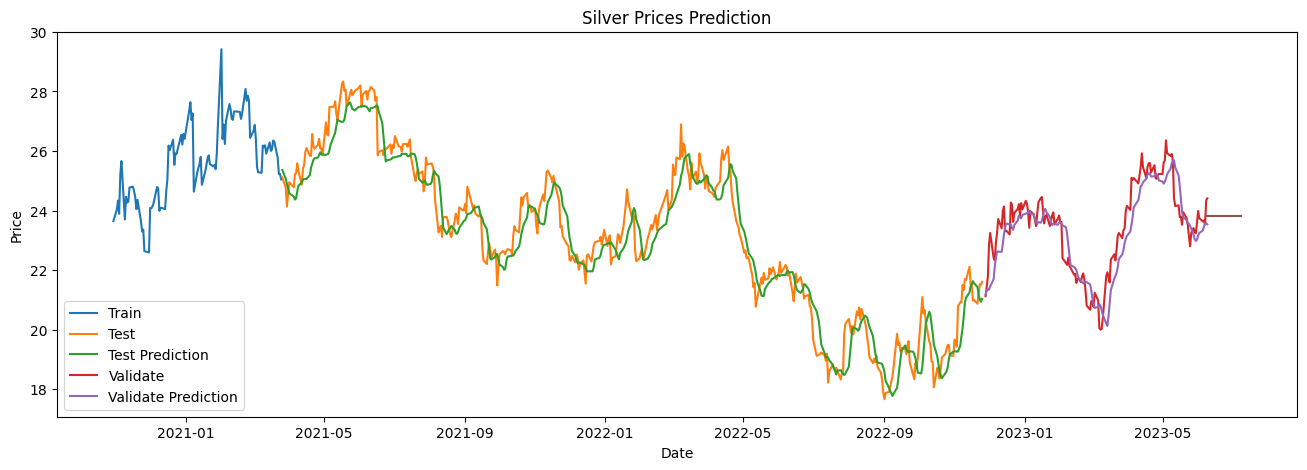

In [28]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Silver Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [29]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.5478578096425758
MAPE:  2.3960178036502566
RMSE:  0.6850381602621307

** Validate **
MAE:  0.5155822081230055
MAPE:  2.2046180601039738
RMSE:  0.6577574419971427


# Split dataset (5-3-2)

---



In [30]:
# 4. Split data
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [31]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [32]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [33]:
# Build the model
model = Sequential()

# Add an LSTM layer with 64 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(LSTM(units=64, input_shape=(x_train.shape[1], 1), return_sequences=True,kernel_regularizer=l2(0.01)))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=True))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=False))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_5_3_2.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.17542, saving model to save_model_5_3_2.hdf5
15/15 - 5s - loss: 0.1754 - 5s/epoch - 341ms/step
Epoch 2/80

Epoch 2: loss improved from 0.17542 to 0.08518, saving model to save_model_5_3_2.hdf5
15/15 - 0s - loss: 0.0852 - 146ms/epoch - 10ms/step
Epoch 3/80

Epoch 3: loss improved from 0.08518 to 0.06969, saving model to save_model_5_3_2.hdf5
15/15 - 0s - loss: 0.0697 - 150ms/epoch - 10ms/step
Epoch 4/80

Epoch 4: loss improved from 0.06969 to 0.04692, saving model to save_model_5_3_2.hdf5
15/15 - 0s - loss: 0.0469 - 148ms/epoch - 10ms/step
Epoch 5/80

Epoch 5: loss did not improve from 0.04692
15/15 - 0s - loss: 0.0518 - 125ms/epoch - 8ms/step
Epoch 6/80

Epoch 6: loss improved from 0.04692 to 0.04293, saving model to save_model_5_3_2.hdf5
15/15 - 0s - loss: 0.0429 - 161ms/epoch - 11ms/step
Epoch 7/80

Epoch 7: loss improved from 0.04293 to 0.03497, saving model to save_model_5_3_2.hdf5
15/15 - 0s - loss: 0.0350 - 156ms/epoch - 10ms/step


In [34]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_5_3_2.hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

22/22 [==============================] - 1s 3ms/step


In [35]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 [==============================] - 0s 3ms/step


In [36]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

9/9 [==============================] - 0s 3ms/step


In [37]:
# Predict the next 30 days
x_input=sc_train[sc_train.shape[0]-5:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=5
i=0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

# Print the final list of predictions
print(lst_output)

[0.7023941]
6
[0.7023941]
7
[0.7023941]
8
[0.7023941]
9
[0.7023941]
10
[0.7023941]
11
[0.7023941]
12
[0.7023941]
13
[0.7023941]
14
[0.7023941]
15
[0.7023941]
16
[0.7023941]
17
[0.7023941]
18
[0.7023941]
19
[0.7023941]
20
[0.7023941]
21
[0.7023941]
22
[0.7023941]
23
[0.7023941]
24
[0.7023941]
25
[0.7023941]
26
[0.7023941]
27
[0.7023941]
28
[0.7023941]
29
[0.7023941]
30
[0.7023941]
31
[0.7023941]
32
[0.7023941]
33
[0.7023941]
34
[0.7023941]
35
[[0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.7023941278457642], [0.

<Figure size 1600x500 with 0 Axes>

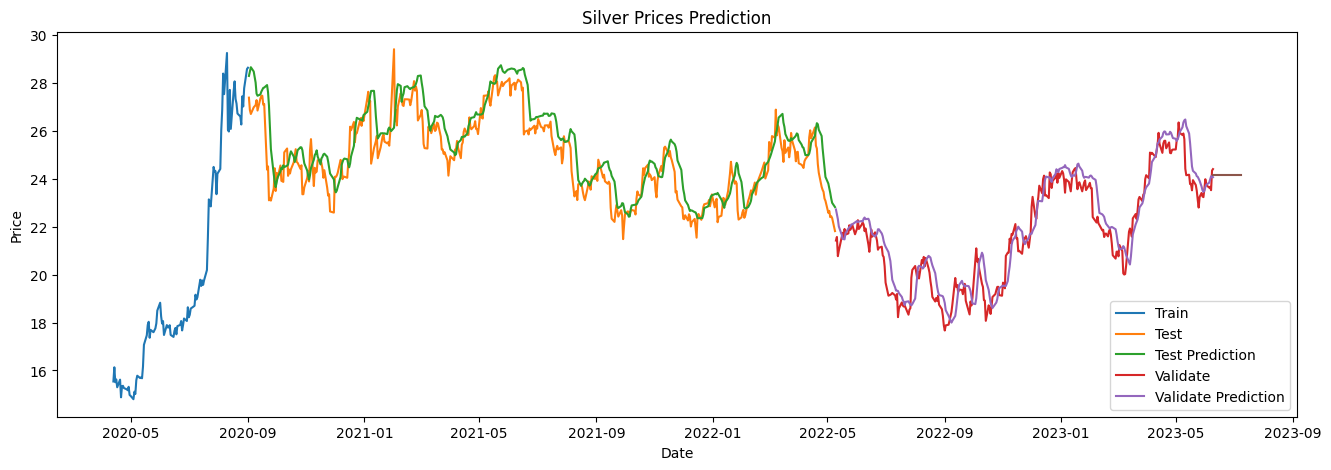

In [38]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.figure(figsize=(16,5))
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Silver Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [39]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.680586667942551
MAPE:  2.7623226094702495
RMSE:  0.9078927845087416

** Validate **
MAE:  0.5762662334644331
MAPE:  2.704888017860345
RMSE:  0.7325915515222176


# Evaluate Model

---
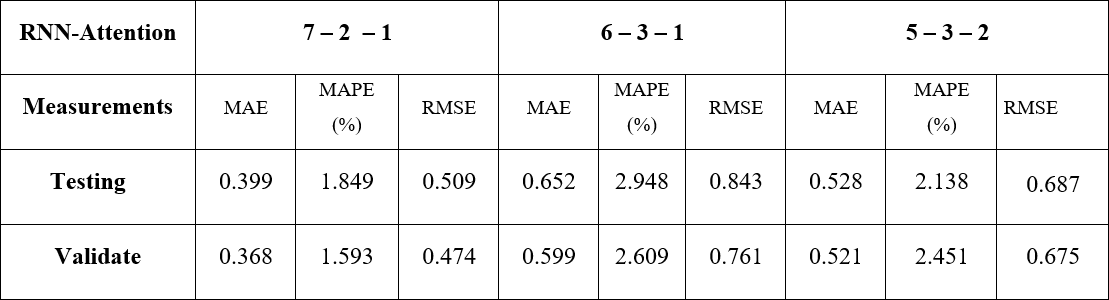